In [14]:
conda install -c conda-forge r-paws r-terra r-optmatch r-sp r-sf r-rgeos r-dplyr r-plyr r-ggplot2 r-mapview r-stringr r-maptools r-gridExtra r-lattice r-MASS r-foreach r-doParallel r-rlang r-tidyr r-magrittr r-aws.s3 r-rgeos r-rlemon r-svd r-sparsem r-survival

also installing the dependencies ‘bitops’, ‘gt’, ‘roxygen2’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
install.packages("s3")
install.packages("optmatch")
install.packages("RItools")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in install.packages("optmatch"):
“installation of package ‘optmatch’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
options(warn=-1)
options(dplyr.summarise.inform = FALSE)

packages <- c("sp","sf","rgeos","dplyr","plyr","ggplot2","mapview","stringr","terra",
              "maptools","gridExtra","lattice","MASS","foreach","optmatch","doParallel","RItools",
              "rlang","tidyr","magrittr","aws.s3","s3")

In [4]:
package.check <- lapply(packages, FUN = function(x) {
  suppressPackageStartupMessages(library(x, character.only = TRUE))
})

In [5]:
s3 <- paws::s3()

In [6]:
iso3<- "GNB"
gediwk<-24

In [7]:
f.path <- "s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/"
gedipath<- "/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/" #Make sure to specify username
f.path3<- "~/output/WDPA_matching_results/" #Rename folder to "output" since DPS looks for this, move up in the code, set as default but allow an argument to change output file


In [8]:
cat("Step 0: Loading global variables to process country", iso3,"with GEDI data until week", gediwk, "\n")

matching_tifs <- c("wwf_biomes","wwf_ecoreg","lc2000","d2roads", "dcities","dem",
                   "pop_cnt_2000","pop_den_2000","slope", "tt2cities_2000", "wc_prec_1990-1999",
                   "wc_tmax_1990-1999","wc_tavg_1990-1999","wc_tmin_1990-1999" )

ecoreg_key <- read.csv(s3_get(paste(f.path,"wwf_ecoregions_key.csv",sep="")))
#unlink(s3_get(paste(f.path,"wwf_ecoregions_key.csv",sep="")))

allPAs <- readRDS(s3_get(paste(f.path,"WDPA_shapefiles/WDPA_polygons/",iso3,"_PA_poly.rds",sep="")))

MCD12Q1 <- rast(s3_get(paste(f.path,"GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif",sep="")))
crs(MCD12Q1)  <- "epsg:6933"

world_region <- rast(s3_get(paste(f.path,"GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif",sep="")))
crs(world_region)  <- "epsg:6933"

s3_path <- paste("/vsis3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_countries/shp/",iso3,".shp",sep="") #Redo this 

adm <- st_read(s3_path)

adm_prj <- project(vect(adm), "epsg:6933")

load(s3_get(paste(f.path,"rf_noclimate.RData",sep="")))

flag <- "run all"

Step 0: Loading global variables to process country GNB with GEDI data until week 24 


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/wwf_ecoregions_key.csv already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/wwf_ecoregions_key.csv

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons/GNB_PA_poly.rds already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_shapefiles/WDPA_polygons/GNB_PA_poly.rds

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif

ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/GEDI_ANCI_CONTINE

Reading layer `GNB' from data source 
  `/vsis3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/WDPA_countries/shp/GNB.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 94 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -16.72844 ymin: 10.92764 xmax: -13.66071 ymax: 12.67943
Geodetic CRS:  WGS 84


ℹ s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/rf_noclimate.RData already exists at /projects/.local/share/R/s3/maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/rf_noclimate.RData



In [9]:
#---------------STEP5. GEDI PROCESSING - using GEDI shots to extract the treatment/control status, also extract the MODIS PFT for AGB prediction---------------- 
# if (file.exists(paste(f.path,"WDPA_GEDI_extract/",iso3,"_wk",gediwk,"/",iso3,"_gedi_extracted_matching_wk",gediwk,".RDS", sep=""))){
cat(paste("Step 5: Performing WK ",gediwk,"GEDI extraction for", iso3,"\n"))
#matched_all <-read.csv(paste(f.path,"WDPA_extract4_residual_PAs/", iso3, "_wk_", gediwk, "_null_matches_rerun.csv",sep="")) 
matched_all<-list.files(paste(f.path3,iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = TRUE)
matched_all

Step 5: Performing WK  24 GEDI extraction for GNB 


[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_11610_matching_results_wk24.RDS"    
 [2] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_145507_matching_results_wk24.RDS"   
 [3] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_29806_matching_results_wk24.RDS"    
 [4] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_317051_matching_results_wk24.RDS"   
 [5] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_33046_matching_results_wk24.RDS"    
 [6] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_33047_matching_results_wk24.RDS"    
 [7] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_33048_matching_results_wk24.RDS"    
 [8] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_33050_matching_results_wk24.RDS"    
 [9] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342655_matching_results_wk24.RDS"   
[10] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342656_matching_results_wk24.RDS"   
[11] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342658_matching_results_wk24.RDS"   
[12] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342659_matching_results_wk24.RDS"   
[13] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342660_matching_results_wk24.RDS"   
[14] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342661_matching_results_wk24.RDS"   
[15] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342662_matching_results_wk24.RDS"   
[16] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342670_matching_results_wk24.RDS"   
[17] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342671_matching_results_wk24.RDS"   
[18] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342672_matching_results_wk24.RDS"   
[19] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342673_matching_results_wk24.RDS"   
[20] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_351088_matching_results_wk24.RDS"   
[21] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_555626105_matching_results_wk24.RDS"
[22] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_555626106_matching_results_wk24.RDS"
[23] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_555703681_matching_results_wk24.RDS"

In [10]:
matched_PAs <- foreach(this_rds=matched_all, .combine = c, .packages=c('sp','magrittr', 'dplyr','tidyr','terra')) %do% {   #non-NA matched results
  matched_PAs=c()
  print(this_rds)
  if(nchar(iso3)>3){
    id_pa <- basename(this_rds)%>%readr::parse_number() %>% unique()  
  } else {
    id_pa <- basename(this_rds)%>%readr::parse_number() %>% unique()
  }
  matched <- readRDS(paste(f.path3,iso3,"_wk",gediwk,"/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))
  if(!is.null(matched)){
    if(nrow(matched)!=0){
      matched_PAs=c(matched_PAs,this_rds) 
    }
  }else {
    # print(this_rds)
    matched_PAs=matched_PAs
  }
  return(matched_PAs)
}
length(matched_PAs)

[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_11610_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_145507_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_29806_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_317051_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_33046_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_33047_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_33048_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_33050_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342655_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342656_matching_results_wk24.RDS"
[1] "/projects/output/WDPA_matching_results/GNB_wk24/GNB_pa_342658

[1] 20

In [11]:
if(flag=="run all"){  #determine how many PAs to run the extraction process
  matched_PAs <- matched_PAs
  cat("Step 5: runing extraction on all", length(matched_PAs),"of non-NA matched results in", iso3,"\n")
} else if (flag=="run remaining"){
  pattern1 = c(paste("wk",gediwk,sep=""),"RDS")
  extracted_PAid <- list.files(paste(f.path3,"WDPA_GEDI_extract/",iso3,"_wk",gediwk,"/",sep=""), full.names = F, pattern=paste0(pattern1, collapse="|"))%>%
    readr::parse_number() %>% unique()
  matched_PA_id <- matched_PAs %>% readr::parse_number()
  runPA_id <- matched_PA_id[!(matched_PA_id %in% extracted_PAid)]
  if (length(runPA_id)>0){
    Pattern2 <-  paste(runPA_id, collapse="|")
    runPA <-  matched_PAs[grepl(Pattern2,matched_PAs)]
    # runPA_ind <- str_detect(matched_PAs, paste(runPA_id, collapse = "|"))
    matched_PAs <-runPA
  } else {
    matched_PAs <- NULL
    cat("Step 5 already done for", iso3, "\n")
  }
}

Step 5: runing extraction on all 20 of non-NA matched results in GNB 


In [12]:
source("matching_func_2024.r")

In [34]:
this_rds<-matched_PAs[4]
id_pa <- basename(this_rds)%>%readr::parse_number() %>% unique()
    
    matched <- readRDS(paste(f.path3,iso3,"_wk",gediwk,"/",iso3,"_pa_",id_pa,"_matching_results_wk24.RDS", sep=""))
    
    if (is.null(matched)==TRUE  | nrow(matched)==0) {
        cat("Matched result is null for PA", id_pa, "quitting...\n")
        next  # Skip to the next iteration
    } else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
    print(table(mras$status[]))
    if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
      cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
      next  # Skip to the next iteration
    } else {
        
      startTime <- Sys.time()
        
      iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)#}  #run filtered csvs on mras for extarction
        
        if (is.null(iso_matched_gedi)) {
        cat("Matched result is null for PA", id_pa, "quitting...\n")
        next  # Skip to the next iteration
        }

      tElapsed <- Sys.time()-startTime
      cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")

      iso_matched_gedi <-  iso_matched_gedi %>%
            dplyr::select("pa_id","status",
                      "wwfbiom","wwfecoreg","shot_number","lon_lowestmode", 
                      "lat_lowestmode", "lon_lowestmode", 
                      "lat_lowestmode","rh25", "rh50", "rh75","rh90", "rh98")  #write to individual country folder
        
      if (length(unique(iso_matched_gedi$wwfbiom)) >1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
      } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
      } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique()
      }

      continent <- unique(iso_matched_gedi$region) %>% getmode()
      print(paste('output df',dim(iso_matched_gedi)))

      dir.create(file.path(paste(f.path3,"WDPA_GEDI_extract/",sep="")),recursive=TRUE)
      saveRDS(iso_matched_gedi, file=paste(f.path3,"WDPA_GEDI_extract/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      write.csv(iso_matched_gedi, file=paste(f.path3,"WDPA_GEDI_extract/",iso3,"_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
      cat(id_pa,"in",iso3,"results is written to dir\n")
    }
    }
    
    return(NULL)

Converting the matched csv to a raster stack for extraction

  0   1 
568 568 
Readng in no.  1 csv of  7 csvs for iso3 GNB 
Reading layer `tile_num_29418_L4A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_29418_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 173700 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -16.79044 ymin: 12.00004 xmax: -16 ymax: 12.99999
Geodetic CRS:  WGS 84
Reading layer `tile_num_29418_L2A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_29418_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, a

NULL

In [99]:
dim(gedi_l24)

[1] 2332936      22

In [100]:
iso_matched_gedi_df <- data.frame()

gedi_l24_sp <- gedi_l24 %>% 
     SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

In [101]:
matched_gedi <- terra::extract(mras,vect(gedi_l24_sp), df=TRUE)

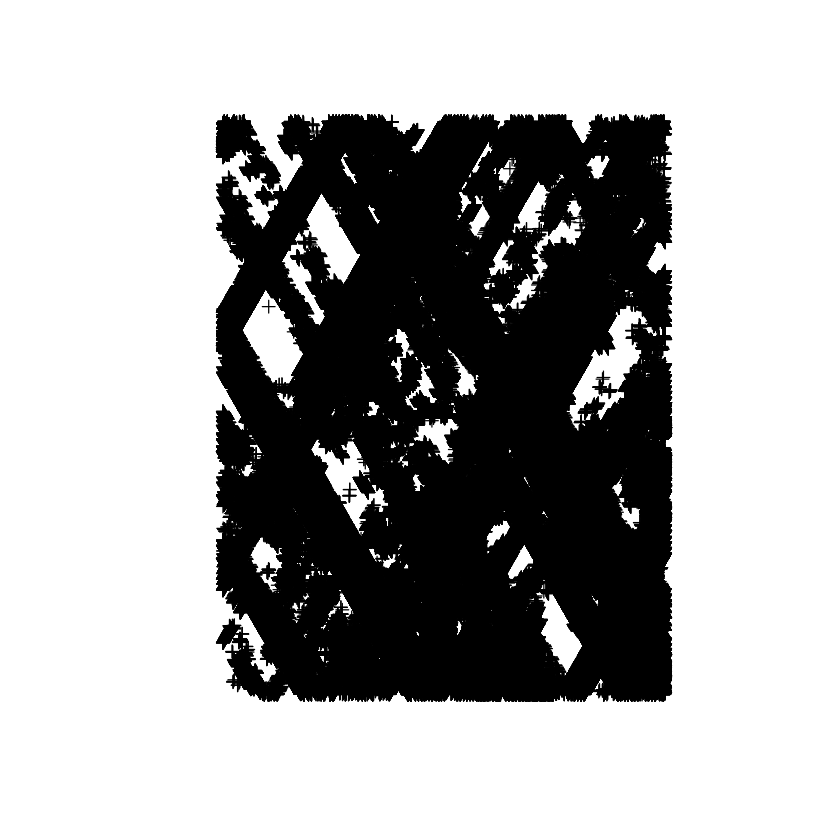

In [102]:
plot(gedi_l24_sp)

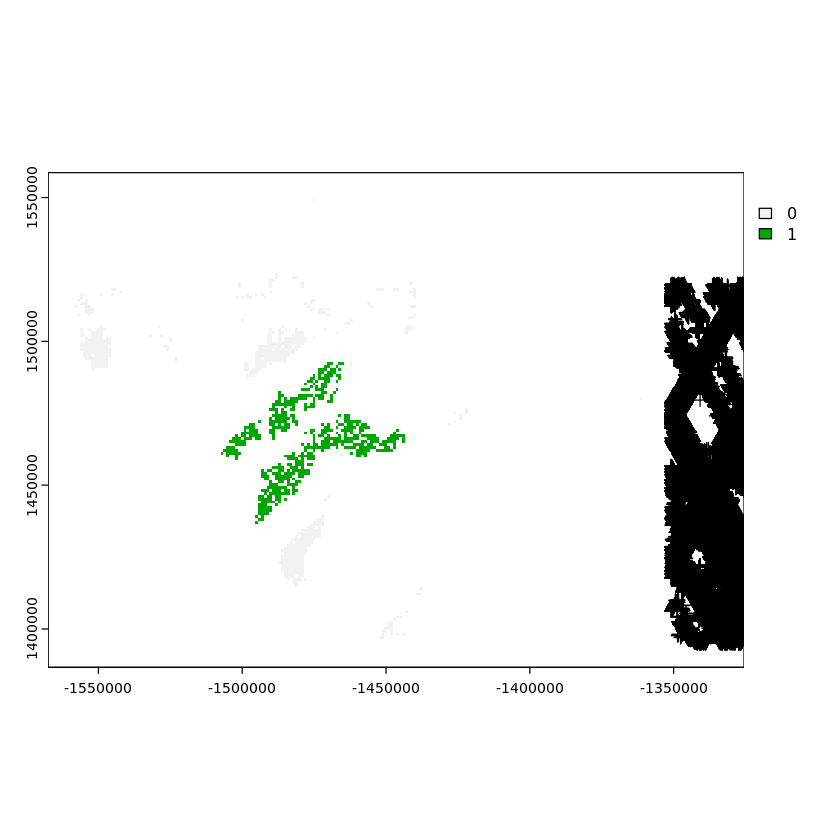

In [103]:
plot(mras$status)
plot(gedi_l24_sp,add=T)

In [19]:
allOut <- read.csv("~/GEDI_PA/vl_GEDI-PA_2024/GNB_pa.csv")

In [15]:
# summary(allOut)

In [20]:
data_sf <- st_as_sf(allOut, coords = c("lon", "lat"), crs = 4326)

In [53]:
results <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                            Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/",sep=""))
    all_gedil2_f <- sapply(results$Contents, function(x) {x$Key})
    pattern=paste(".gpkg",sep="")
    all_gedil2_f <- grep(pattern, all_gedil2_f, value=TRUE)
    all_gedil2_f <- basename(all_gedil2_f)[4:5] #Currently specifying working files
    
    results4 <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                                Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/",sep=""))
    all_gedil4_f <- sapply(results4$Contents, function(x) {x$Key})
    pattern4=paste(".gpkg",sep="")
    all_gedil4_f <- grep(pattern4, all_gedil4_f, value=TRUE)
    all_gedil4_f <- basename(all_gedil4_f)[4:5] #Currently specifying working files

In [14]:
all_gedil2_f

[1] "tile_num_29418_L2A.gpkg" "tile_num_29419_L2A.gpkg"
 [3] "tile_num_29598_L2A.gpkg" "tile_num_29599_L2A.gpkg"
 [5] "tile_num_29600_L2A.gpkg" "tile_num_29778_L2A.gpkg"
 [7] "tile_num_29779_L2A.gpkg" "tile_num_29780_L2A.gpkg"
 [9] "tile_num_29958_L2A.gpkg" "tile_num_29959_L2A.gpkg"

In [141]:
gedil4_f <- as.data.frame(st_read(paste(gedipath,"WDPA_gedi_L4A_tiles/",all_gedil4_f[this_csvid],sep="")))

Reading layer `tile_num_29959_L4A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_29959_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 149672 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -14 ymin: 11 xmax: -13 ymax: 12
Geodetic CRS:  WGS 84


In [ ]:
dim(gedil4_f)

In [142]:
gedil2_f <- as.data.frame(st_read(paste(gedipath,"WDPA_gedi_L2A_tiles/",all_gedil2_f[this_csvid],sep="")))

Reading layer `tile_num_29959_L2A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_29959_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 1114307 features and 17 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -14 ymin: 11 xmax: -13 ymax: 12
Geodetic CRS:  WGS 84


In [31]:
results <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                            Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/",sep=""))
    all_gedil2_f <- sapply(results$Contents, function(x) {x$Key})
    pattern=paste(".gpkg",sep="")
    all_gedil2_f <- grep(pattern, all_gedil2_f, value=TRUE)
    all_gedil2_f <- basename(all_gedil2_f)[4:5]

all_gedil2_f

[1] "tile_num_29599_L2A.gpkg" "tile_num_29600_L2A.gpkg"

In [70]:
extract_gedi <- function(matched, mras){
    results <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                            Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/",sep=""))
    all_gedil2_f <- sapply(results$Contents, function(x) {x$Key})
    pattern=paste(".gpkg",sep="")
    all_gedil2_f <- grep(pattern, all_gedil2_f, value=TRUE)
    all_gedil2_f <- basename(all_gedil2_f)[4:5] #Currently specifying working files
    
    results4 <- s3$list_objects_v2(Bucket = "maap-ops-workspace", 
                                Prefix=paste("shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/",sep=""))
    all_gedil4_f <- sapply(results4$Contents, function(x) {x$Key})
    pattern4=paste(".gpkg",sep="")
    all_gedil4_f <- grep(pattern4, all_gedil4_f, value=TRUE)
    all_gedil4_f <- basename(all_gedil4_f)[4:5] #Currently specifying working files
  
    # Initialize an empty list to store results
    results_list <- list()
    iso_matched_gedi_df <- NULL # Initialize before loop

            # Iterate over the sequence of indices for your files
    for (this_csvid in seq_along(all_gedil2_f)) {
                cat("Reading in no. ", this_csvid, "csv of ", length(all_gedil2_f), "csvs for iso3", iso3, "\n")
                
                # Read GEDI L4A data
                gedil4_f_path <- paste(gedipath, "WDPA_gedi_L4A_tiles/", all_gedil4_f[this_csvid], sep = "")
                gedil4_f <- as.data.frame(st_read(gedil4_f_path))
                
                # Read GEDI L2A data
                gedil2_f_path <- paste(gedipath, "WDPA_gedi_L2A_tiles/", all_gedil2_f[this_csvid], sep = "")
                gedil2_f <- as.data.frame(st_read(gedil2_f_path))
            
                # Check if GEDI L4A data is empty
                if (nrow(gedil4_f) < 1) {
                    cat("Error: No data for GEDI L4A\n")
                    gedi_l24 <- gedil2_f
                    gedi_l24$agbd <- NA
                    gedi_l24$agbd_se <- NA
                    gedi_l24$agbd_t <- NA
                    gedi_l24$agbd_t_se <- NA
                } else {
                    # Select relevant columns from GEDI L4A
                    gedi_l4_sub <- gedil4_f %>%
                        dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
                    
                    # Join with GEDI L2A data
                    gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by = "shot_number")
                }
            
                print(dim(gedi_l24))
            
                # Initialize empty spatial object for the current iteration
                gedi_l24_sp <- NULL
            
                # Convert to spatial points data frame if there is data
                if (nrow(gedi_l24) > 0) {
                    gedi_l24_sp <- SpatialPointsDataFrame(
                        coords = gedi_l24[, c("lon_lowestmode", "lat_lowestmode")],
                        data = gedi_l24,
                        proj4string = CRS("+init=epsg:4326")
                    ) %>% spTransform(CRS("+init=epsg:6933"))
                matched_gedi <- terra::extract(mras,vect(gedi_l24_sp), df=TRUE)
                matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
                matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
                convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
            print(dim(iso_matched_gedi_df))
         }
        
        # Store results in a list
        results_list[[this_csvid]] <- iso_matched_gedi_df
    }
    
    # Combine all results
    if (!is.null(iso_matched_gedi_df)) {
        iso_matched_gedi_df <- do.call(rbind, results_list)
    }
    
    cat("Done GEDI processing\n")
    return(iso_matched_gedi_df)
}

In [147]:
ex_out <- for (this_csvid in seq_along(length(all_gedil2_f))) {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(all_gedil2_f),"csvs for iso3",iso3,"\n")

    # for (this_gedi4 in all_gedil4_f[this_csvid]){
            gedil4_f <- as.data.frame(st_read(paste(gedipath,"WDPA_gedi_L4A_tiles/",all_gedil4_f[this_csvid],sep="")))
    # }
    # for (this_gedi2 in all_gedil2_f[this_csvid]){
            gedil2_f <- as.data.frame(st_read(paste(gedipath,"WDPA_gedi_L2A_tiles/",all_gedil2_f[this_csvid],sep="")))
    # }
            if (nrow(gedil4_f) < 1){   #is.na(gedi_l4) || 
              cat("error")
              gedi_l24 <- gedil2_f
              gedi_l24$agbd <- NA
              gedi_l24$agbd_se <- NA
              gedi_l24$agbd_t <- NA
              gedi_l24$agbd_t_se <- NA
            } else {
              gedi_l4_sub <- gedil4_f %>%
                dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
              gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by="shot_number")

            }

        print(dim(gedi_l24))
        iso_matched_gedi_df <- data.frame()
        if(nrow(gedi_l24)>0){
            gedi_l24_sp <- gedi_l24 %>% 
                SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))
        }
        return(gedi_l24_sp)
}

Readng in no.  1 csv of  10 csvs for iso3 GNB 
Reading layer `tile_num_29418_L4A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_29418_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 173700 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -16.79044 ymin: 12.00004 xmax: -16 ymax: 12.99999
Geodetic CRS:  WGS 84
Reading layer `tile_num_29418_L2A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_29418_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 846905 features and 17 fields
Geome

In [16]:
results_list <- list()

# Iterate over the sequence of indices for your files
for (this_csvid in seq_along(all_gedil2_f)) {
    cat("Reading in no. ", this_csvid, "csv of ", length(all_gedil2_f), "csvs for iso3", iso3, "\n")
    
    # Read GEDI L4A data
    gedil4_f_path <- paste(gedipath, "WDPA_gedi_L4A_tiles/", all_gedil4_f[this_csvid], sep = "")
    gedil4_f <- as.data.frame(st_read(gedil4_f_path))
    
    # Read GEDI L2A data
    gedil2_f_path <- paste(gedipath, "WDPA_gedi_L2A_tiles/", all_gedil2_f[this_csvid], sep = "")
    gedil2_f <- as.data.frame(st_read(gedil2_f_path))

    # Check if GEDI L4A data is empty
    if (nrow(gedil4_f) < 1) {
        cat("Error: No data for GEDI L4A\n")
        gedi_l24 <- gedil4_f
        gedi_l24$agbd <- NA
        gedi_l24$agbd_se <- NA
        gedi_l24$agbd_t <- NA
        gedi_l24$agbd_t_se <- NA
    } else {
        # Select relevant columns from GEDI L4A
        gedi_l4_sub <- gedil4_f %>%
            dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
        
        # Join with GEDI L2A data
        gedi_l24 <- inner_join(gedil2_f, gedi_l4_sub, by = "shot_number")
    }

    print(dim(gedi_l24))

    # Initialize empty spatial object for the current iteration
    gedi_l24_sp <- NULL

    # Convert to spatial points data frame if there is data
    if (nrow(gedi_l24) > 0) {
        gedi_l24_sp <- SpatialPointsDataFrame(
            coords = gedi_l24[, c("lon_lowestmode", "lat_lowestmode")],
            data = gedi_l24,
            proj4string = CRS("+init=epsg:4326")
        ) %>% spTransform(CRS("+init=epsg:6933"))
    }
    
    # Store result in the list
    results_list[[this_csvid]] <- gedi_l24_sp
}

Reading in no.  1 csv of  3 csvs for iso3 GNB 
Reading layer `tile_num_29418_L4A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_29418_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 173700 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -16.79044 ymin: 12.00004 xmax: -16 ymax: 12.99999
Geodetic CRS:  WGS 84
Reading layer `tile_num_29418_L2A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_29418_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 846905 features and 17 fields
Geome

In [22]:
single_result <- results_list[[2]]

In [23]:
single_result_sf <- st_as_sf(single_result)

In [55]:
matched<-readRDS("~/output/WDPA_matching_results/GNB_wk24/GNB_pa_351088_matching_results_wk24.RDS")

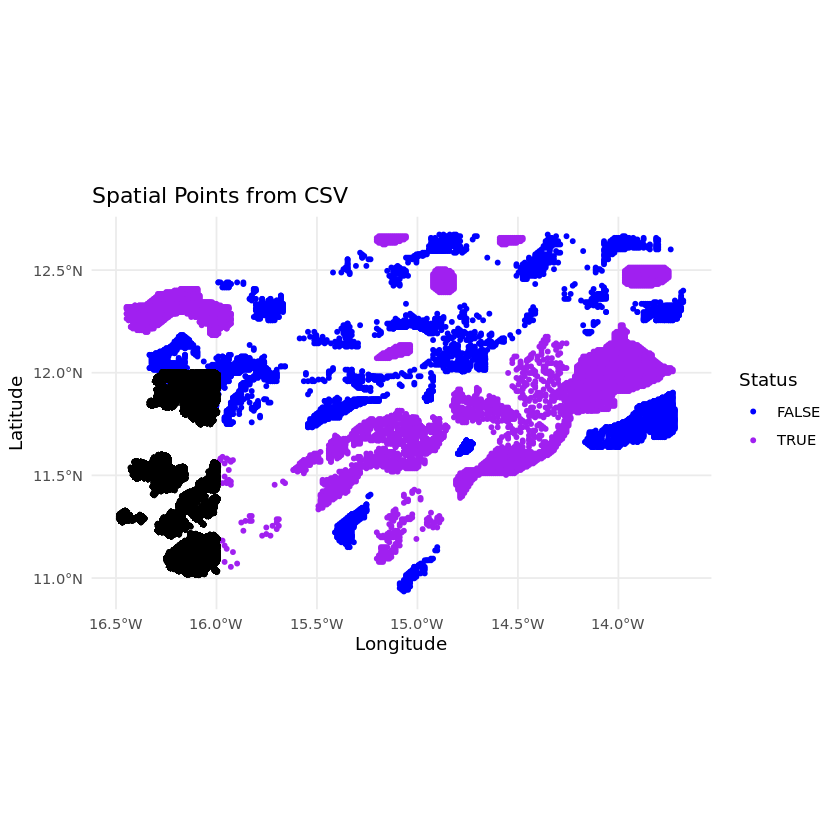

In [24]:
ggplot(data_sf) +
  geom_sf(aes(color = status), size = 1) + 
  geom_sf(data = single_result_sf, color = "black", linetype = "dashed") +
  theme_minimal() +
  scale_color_manual(values = c("TRUE" = "purple", "FALSE" = "blue"))+
  labs(title = "Spatial Points from CSV",
       x = "Longitude",
       y = "Latitude",
      color = "Status")

In [57]:
all_gedil2_f

[1] "tile_num_29599_L2A.gpkg" "tile_num_29600_L2A.gpkg"

In [62]:
gediGrid<-st_read("~/my-public-bucket/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_29599_L2A.gpkg")

Reading layer `tile_num_29599_L2A' from data source 
  `/projects/my-public-bucket/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_29599_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 503976 features and 17 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -16 ymin: 11.00001 xmax: -15 ymax: 12
Geodetic CRS:  WGS 84


In [66]:
str(matched)

tibble [272 × 22] (S3: tbl_df/tbl/data.frame)
 $ lat              : num [1:272] 11.4 11.4 11.4 11.4 11.4 ...
 $ lon              : num [1:272] -15 -15.1 -15.1 -15 -15.1 ...
 $ UID              : int [1:272] 8 12 23 49 59 60 129 166 170 184 ...
 $ status           : logi [1:272] TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ land_cover       : Factor w/ 5 levels "l1_forest","l2_grassland",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ wwfbiom          : Factor w/ 2 levels "Tropical & Subtropical Grasslands, Savannas & Shrublands",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ wwfecoreg        : Factor w/ 2 levels "Guinean forest-savanna mosaic",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ elevation        : num [1:272] 8 5 5 21 30 13 7 11 5 7 ...
 $ slope            : num [1:272] 0.363 0.196 0.196 0.603 0.348 ...
 $ mean_temp        : num [1:272] 27.7 27.7 27.7 27.7 27.7 ...
 $ max_temp         : num [1:272] 37.8 37.8 37.8 37.8 37.8 ...
 $ min_temp         : num [1:272] 16.9 17 17 17 17 ...
 $ prec             : num [1:272] 7754 7710 7710 77

In [133]:
str(vect(gedi_l24_sp))

S4 class 'SpatVector' [package "terra"]


ID,status,pa_id,wwfbiom,wwfecoreg,UID,pft,region,filename,rh70,⋯,lat_lowestmode,rh50,shot_number,rh60,agbd,agbd_se,agbd_t,agbd_t_se,geometry,stratum
<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<GEOMETRY [°]>,<chr>


In [51]:
test<-st_as_sf(matched, coords = c("lon", "lat"), crs = 4326)
res <- st_as_sf(gedi_l24_sp)
ggplot(test) +
  geom_sf(aes(color = status), size = 1) + 
  geom_sf(data = res, color = "black", linetype = "dashed") +
  theme_minimal() +
  scale_color_manual(values = c("TRUE" = "purple", "FALSE" = "blue"))+
  labs(title = "Spatial Points from CSV",
       x = "Longitude",
       y = "Latitude",
      color = "Status")

ERROR: Error in st_as_sf(gedi_l24_sp): object 'gedi_l24_sp' not found


In [28]:
 mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)})

Converting the matched csv to a raster stack for extraction


In [50]:
print(table(mras$status[]))


  0   1 
568 568 


In [71]:
iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)

Reading in no.  1 csv of  2 csvs for iso3 GNB 
Reading layer `tile_num_29599_L4A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_29599_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 126259 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -15.99999 ymin: 11.00002 xmax: -15 ymax: 12
Geodetic CRS:  WGS 84
Reading layer `tile_num_29599_L2A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_29599_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 503976 features and 17 fields
Geometry ty

In [72]:
iso_matched_gedi

ID,status,pa_id,wwfbiom,wwfecoreg,UID,pft,region,filename,rh30,⋯,rh20,rh40,rh50,lat_lowestmode,agbd,agbd_se,agbd_t,agbd_t_se,geometry,stratum
<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<GEOMETRY [°]>,<chr>


In [27]:
#### THIS LOOP DOES NOT CONTINUE LOOPING ####

for(this_rds in matched_PAs){
   
    cat("Extracting for no. ", match(this_rds,matched_PAs),"pa out of", length(matched_PAs),"\n")
   
    id_pa <- basename(this_rds)%>%readr::parse_number() %>% unique()
    
    matched <- readRDS(paste(f.path3,iso3,"_wk",gediwk,"/",iso3,"_pa_",id_pa,"_matching_results_wk24.RDS", sep=""))
    
    if (is.null(matched)==TRUE  | nrow(matched)==0) {
        cat("Matched result is null for PA", id_pa, "quitting...\n")
        next  # Skip to the next iteration
    } else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
    print(table(mras$status[]))
    if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
      cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
      next  # Skip to the next iteration
    } else {
        
      startTime <- Sys.time()
        
      iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)#}  #run filtered csvs on mras for extarction
        
        if (is.null(iso_matched_gedi)) {
        cat("Matched result is null for PA", id_pa, "quitting...\n")
        next  # Skip to the next iteration
        }

      tElapsed <- Sys.time()-startTime
      cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")

      iso_matched_gedi <-  iso_matched_gedi %>%
            dplyr::select("pa_id","status",
                      "wwfbiom","wwfecoreg","shot_number","lon_lowestmode", 
                      "lat_lowestmode", "lon_lowestmode", 
                      "lat_lowestmode","rh25", "rh50", "rh75","rh90", "rh98")  #write to individual country folder
        
      if (length(unique(iso_matched_gedi$wwfbiom)) >1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
      } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
      } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique()
      }

      continent <- unique(iso_matched_gedi$region) %>% getmode()
      print(paste('output df',dim(iso_matched_gedi)))

      dir.create(file.path(paste(f.path3,"WDPA_GEDI_extract/",sep="")),recursive=TRUE)
      saveRDS(iso_matched_gedi, file=paste(f.path3,"WDPA_GEDI_extract/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      write.csv(iso_matched_gedi, file=paste(f.path3,"WDPA_GEDI_extract/",iso3,"_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
      cat(id_pa,"in",iso3,"results is written to dir\n")
    }
    }
    
    return(NULL)
}


Extracting for no.  1 pa out of 20 
Converting the matched csv to a raster stack for extraction

 0  1 
25 25 
Readng in no.  1 csv of  7 csvs for iso3 GNB 
Reading layer `tile_num_29418_L4A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L4A_tiles/tile_num_29418_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 173700 features and 11 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -16.79044 ymin: 12.00004 xmax: -16 ymax: 12.99999
Geodetic CRS:  WGS 84
Reading layer `tile_num_29418_L2A' from data source 
  `/vsis3/maap-ops-workspace/shared/abarenblitt/GEDI_global_PA_v2/WDPA_gedi_L2A_tiles/tile_num_29418_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string =

In [1]:
print(matched_PAs)

ERROR: Error in print(matched_PAs): object 'matched_PAs' not found


In [ ]:
## Changed error catching and loop now works ##
matched_PAs<-matched_PAs[8:20]

for (this_rds in matched_PAs) {
    
    # Extract PA ID from the filename
    id_pa <- basename(this_rds) %>% readr::parse_number() %>% unique()
    
    # Construct the path to read the RDS file
    rds_path <- paste(f.path3, iso3, "_wk", gediwk, "/", iso3, "_pa_", id_pa, "_matching_results_wk24.RDS", sep = "")
    
    # Read the RDS file with error handling
    matched <- tryCatch({
        readRDS(rds_path)
    }, error = function(e) {
        cat("Error reading RDS file for PA", id_pa, ":", e$message, "\n")
        return(NULL)
    })
    
    # Skip iteration if matched is NULL or has no rows
    if (is.null(matched) || nrow(matched) == 0) {
        cat("Matched result is null or empty for PA", id_pa, "quitting...\n")
        next  # Skip to the next iteration
    }
    
    # Convert matched data frame to raster stack with error handling
    mras <- tryCatch({
        matched2ras(matched)
    }, error = function(e) {
        cat("Error converting matched data to raster stack for PA", id_pa, ":", e$message, "\n")
        return(NULL)
    })
    
    # Check if raster stack is valid
    if (is.null(mras) || any(table(mras$status[]) == 0)) {
        cat("Rasterized results unbalanced or null for PA", id_pa, "quitting...\n")
        next  # Skip to the next iteration
    }
    
    # Start timing for extraction
    startTime <- Sys.time()
    
    # Extract GEDI data with error handling
    iso_matched_gedi <- tryCatch({
        extract_gedi(matched = matched, mras = mras)
    }, error = function(e) {
        cat("Error extracting GEDI data for PA", id_pa, ":", e$message, "\n")
        return(NULL)
    })
    
    # Check if extraction results are valid
    if (is.null(iso_matched_gedi)) {
        cat("GEDI extraction result is null for PA", id_pa, "quitting...\n")
        next  # Skip to the next iteration
    }
    
    # Calculate elapsed time
    tElapsed <- Sys.time() - startTime
    cat(tElapsed, "for extracting all PAs in", iso3, "\n")
    cat("Done GEDI for PA", match(this_rds, matched_PAs), "out of", length(matched_PAs), "\n")
    
    # Process and select columns
    iso_matched_gedi <- iso_matched_gedi %>%
        dplyr::select("pa_id", "status", "wwfbiom", "wwfecoreg", "shot_number", "lon_lowestmode",
                      "lat_lowestmode", "rh25", "rh50", "rh75", "rh90", "rh98","UID")
    
    # Determine biome name
    if (length(unique(iso_matched_gedi$wwfbiom)) > 1) {
        pabiome <- iso_matched_gedi$wwfbiom %>%
            unique() %>%
            gsub('\\b(\\pL)\\pL{2,}|.', '\\U\\1', ., perl = TRUE) %>%
            str_c(collapse = "+")
    } else if (length(unique(iso_matched_gedi$wwfbiom)) == 1) {
        pabiome <- iso_matched_gedi$wwfbiom %>%
            unique() %>%
            gsub('\\b(\\pL)\\pL{2,}|.', '\\U\\1', ., perl = TRUE)
    } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique()
    }
    
    # Determine continent mode
    continent <- unique(iso_matched_gedi$region) %>% getmode()
    
    # Print dimensions of output dataframe
    cat('Output df dimensions:', dim(iso_matched_gedi), "\n")
    
    # Create output directory if it does not exist
    dir.create(file.path(f.path3, "WDPA_GEDI_extract"), recursive = TRUE, showWarnings = FALSE)
    
    # Save results to RDS and CSV files
    saveRDS(iso_matched_gedi, file = paste(f.path3, "WDPA_GEDI_extract/", iso3, "_pa_", id_pa, 
                                           "_gedi_wk_", gediwk, "_conti_", "biome_", pabiome, ".RDS", sep = ""))
    write.csv(iso_matched_gedi, file = paste(f.path3, "WDPA_GEDI_extract/", iso3, "_pa_", id_pa, 
                                              "_iso_matched_gedi_sub_wk_", gediwk, ".csv", sep = ""))
    
    cat(id_pa, "in", iso3, "results are written to directory\n")
}